<a href="https://colab.research.google.com/github/pythonuzgit/elmurodov/blob/master/Climate_change_analysis_with_Hugging_Face_using_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from tqdm.notebook import tqdm

import transformers 
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch.nn as nn

In [7]:
import warnings
warnings.filterwarnings("ignore")

In [8]:
df = pd.read_csv('/content/climate_change_faqs.csv')

df.set_index('source', inplace=True)

df.head()

,faq,text_type
source,,
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,If Understanding of the Climate System Has Inc...,q
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,The models used to calculate the IPCC’s temper...,a
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,How Do We Know the World Has Warmed?,q
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,Evidence for a warming world comes from multip...,a
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,Have There Been Any Changes in Climate Extremes?,q


In [9]:
df.text_type.value_counts()

q    188
a    188
Name: text_type, dtype: int64

In [10]:
df.isnull().sum()

faq          0
text_type    0
dtype: int64

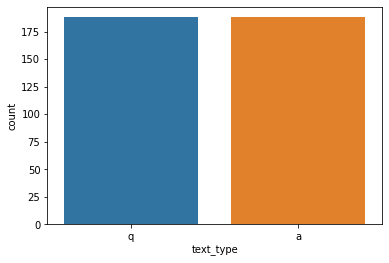

In [11]:
sns.countplot(df.text_type)

There is no imbalance in data

In [12]:
df.shape

(376, 2)

Validation and Training data also has the same target distribution

In [13]:
df.text_type = df.text_type.apply({'q':0,'a':1}.get)

In [14]:
df.head()

,faq,text_type
source,,
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,If Understanding of the Climate System Has Inc...,0
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,The models used to calculate the IPCC’s temper...,1
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,How Do We Know the World Has Warmed?,0
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,Evidence for a warming world comes from multip...,1
https://www.ipcc.ch/site/assets/uploads/2020/05/WGI_AR5_FAQ_EN.pdf,Have There Been Any Changes in Climate Extremes?,0


In [15]:
class_name = ['q', 'a']

Setting device

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
device

device(type='cpu')

In [18]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [19]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Loading pre-trained bert tokenizer

100%|██████████| 376/376 [00:02<00:00, 170.51it/s]


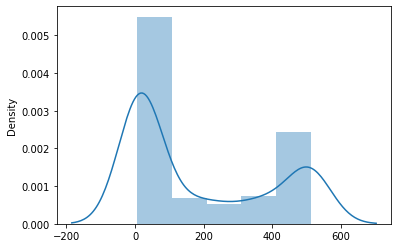

In [20]:
from tqdm import tqdm
token_lens = []
for txt in tqdm(df.faq):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))

sns.distplot(token_lens)

as we can see the largest length of sentence is about 520 but that length is going out memory so we will use smaller max_length

In [21]:
MAX_LEN = 120

In [22]:
from torch.utils.data import Dataset, DataLoader

class faqDataset(Dataset):
  def __init__(self, faqs, targets, tokenizer, max_len):
    self.faqs = faqs
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len 

  def __len__(self):
    return len(self.faqs) 

  def __getitem__(self, item):
    faq = str(self.faqs[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
        faq,
        add_special_tokens = True,
        max_length = self.max_len,
        return_token_type_ids = False,
        pad_to_max_length = True,
        return_attention_mask = True,
        return_tensors = 'pt'
    )   

    return {
        "review_text" : faq,
        'input_ids' : encoding['input_ids'].flatten(),
        'attention_mask' : encoding['attention_mask'].flatten(),
        'targets' : torch.tensor(target, dtype = torch.long)
    }



Training/Validation Split

In [23]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df, test_size = 0.25, random_state = 42,
                                    stratify = df.text_type.values )

df_val, df_test = train_test_split(df_valid, test_size=0.5, random_state=42 )

df_train.shape, df_test.shape, df_val.shape

((282, 2), (47, 2), (47, 2))

In [24]:
def create_data_loader(df,tokenizer,max_len,batch_size):
  ds = faqDataset(
      faqs = df.faq.to_numpy(), 
      targets = df.text_type.to_numpy(),
      tokenizer = tokenizer,
      max_len=max_len)
  
  return DataLoader(ds,
                    batch_size=batch_size,
                    num_workers=4)

In [25]:
BATCH_SIZE = 32
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [26]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):

    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    #self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.out1 = nn.Linear(self.bert.config.hidden_size, 128)
    self.drop1 = nn.Dropout(p=0.4)
    self.relu = nn.ReLU()
    self.out = nn.Linear(128, n_classes)

  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask, return_dict=False
    )
    #output = self.relu(pooled_output)
    output = self.drop(pooled_output)
    output = self.out1(output)
    output = self.relu(output)
    output = self.drop1(output)
    return self.out(output)  
  

In [28]:
model = SentimentClassifier(len(class_name))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [29]:
EPOCHS = 5
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)
#class_weights = torch.FloatTensor(class_weights).to(device)
#weight=class_weights
loss_fn = nn.CrossEntropyLoss().to(device)

Initializing optimizer and loss function for our model

In [30]:
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
  model = model.train()
  losses = []
  correct_predictions = 0

  for data in data_loader:
    input_ids = data['input_ids'].to(device)
    attention_mask = data['attention_mask'].to(device)
    targets = data['targets'].to(device)

    outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs,targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

function to train our model on each epoch

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )

      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)    

function to evaluate the model

In [32]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
      model,
      train_data_loader,
      loss_fn,
      optimizer,
      device,
      scheduler,
      len(df_train)
      )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
      model,
      val_data_loader,
      loss_fn,
      device,
      len(df_val)
      )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------
Train loss 0.4470486640930176 accuracy 0.8439716312056738
Val   loss 0.13516080379486084 accuracy 1.0

Epoch 2/5
----------
Train loss 0.06613805972867542 accuracy 1.0
Val   loss 0.016586597077548504 accuracy 1.0

Epoch 3/5
----------
Train loss 0.015106128218273321 accuracy 1.0
Val   loss 0.006299324333667755 accuracy 1.0

Epoch 4/5
----------
Train loss 0.007062510587275028 accuracy 1.0
Val   loss 0.004454721696674824 accuracy 1.0

Epoch 5/5
----------
Train loss 0.006004176826940643 accuracy 1.0
Val   loss 0.004107971442863345 accuracy 1.0



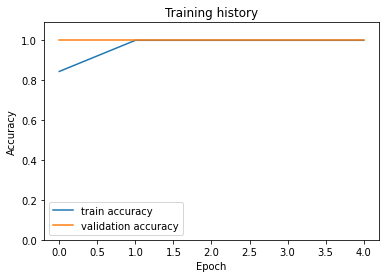

In [37]:
import matplotlib.pyplot as plt
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1.09]);

In [38]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

1.0

In [39]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [40]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [41]:
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

              precision    recall  f1-score   support

           q       1.00      1.00      1.00        22
           a       1.00      1.00      1.00        25

    accuracy                           1.00        47
   macro avg       1.00      1.00      1.00        47
weighted avg       1.00      1.00      1.00        47



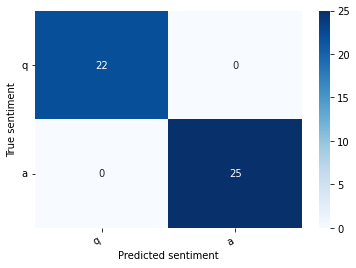

In [42]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_name, columns=class_name)
show_confusion_matrix(df_cm)